# madic: MAtrix Dependent Interference Correction for targeted mass spectrometry data

# Table of contents
(links work in a Jupyter notebook but not on Github)
- [Loading data](#loading)
- [Quality control pipeline](#pipeline)
    - [Transition ratio agreement](#tr)
    - [Transition retention time agreement](#rt)
        - [(Optional) Recompute transition retention time after chromatogram smoothing](#recompute)
    - [Signal to noise](#sn)
    - [QC pass for all replicates](#rep)
    - [QC simplified](#simplified)
- [Identifying interference](#interference)
    - [Interference correction](#correction)

In [1]:
import madic
import matplotlib.pyplot as plt
%matplotlib inline

# Loading data <a name="loading"></a>

**Overview**

In this example dataset we have a 0 ppm (zero parts per million) blank sample and a spiked sample at 5 ppm, each with two injections.

For each sample, we are measuring heavy (stable isotope labeled internal standard) and light versions of two peptides (for simplicity).

For the reference dataset, we have two injections of a synthetic standard peptide mix that enable us to calculate reference transition ratios

Let's load sample data as well as reference data containing injections of synthetic standards

In [2]:
# samples have the following naming format: Mix1_#ppm
# with _1 or _2 appended to indicate injection replicate
data = madic.io.read_transition_report('madic_skyline_daily_data.csv',
                                       delimiter='_',
                                       delimiter_pos=1)

# reference data have the following naming format: synthetic_mix_#
ref = madic.io.read_transition_report('madic_skyline_daily_reference.csv')

The data is contained in a <a href="https://pandas.pydata.org" target="_blank">Pandas</a> DataFrame where each row contains data for a single transition. For example, the first row of data corresponds to the the light y9 transition of the FFVAPFPEVFGK peptide within the Mix1_0ppm_1 replicate:

In [3]:
data.head(1)

,rep,acq_time,pro,pep,prod_ion,label,rt,area,rt_start,rt_end,times,intensities,sample_name,intensities_arr,times_arr
0,Mix1_0ppm_1,5/25/2017 20:31:24,Milk.Bos_d_9,FFVAPFPEVFGK,y9,light,23.82,1716,23.73,23.89,"23.33365,23.34878,23.36388,23.379,23.3941,23.4...","0,540,213,383,477,351,220,364,427,1739,2040,18...",0ppm,"[163.2, 242.9, 322.6, 392.8, 328.8, 359.0, 367...","[23.33365, 23.34878, 23.36388, 23.379, 23.3941..."


You may notice there are a couple of unusual columns: times, intensities, times_arr, and intensities_arr. The former two are exported by Skyline-daily and contain raw chromatogram time and intensity values, respectively, formatted as a long string of comma-separated values. Their "_arr" column counterparts contain these data as numeric arrays, which allows us to plot and analyze them more easily.

Here is an overview of the data we're working with:

In [4]:
print('Samples:\t{}'.format(data.sample_name.unique()))
print('Replicates:\t{}'.format(data.rep.unique()))
print('Peptides:\t{}'.format(list(data.pep.unique())))

Samples:	['0ppm' '5ppm']
Replicates:	['Mix1_0ppm_1' 'Mix1_0ppm_2' 'Mix1_5ppm_1' 'Mix1_5ppm_2']
Peptides:	['FFVAPFPEVFGK', 'YLGYLEQLLR']


And here is a visual overview of the data:

The vertical gray bars indicate the peak boundaries and the transitions are colored by peptide (row) according to the legened in each Reference panel

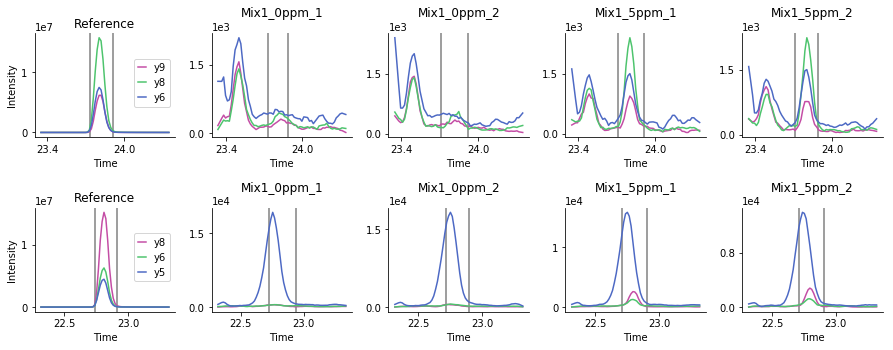

In [5]:
f = madic.plotting.plot_panel_array(data, ref)

# Quality control pipeline <a name="pipeline"></a>

The QC pipeline consists of four parts, the first three are:
1. Transition ratio agreement with reference values (derived from the reference data)
2. Individual transition retention times agree with the mean heavy peak retention time
  - Note that in Skyline / Skyline-daily, transition retention times are calculated without chromatogram smoothing. To improve transition retention time calling for noisy data, this pipeline recomputes transition retention times after applying a Savitzky-Golay filter
3. A distinguished peak compared to the background, calculated as peak height vs. background using the sum of transition chromatogram intensities


The fourth requires the all sample replicates pass all three of the above metrics

## Transition ratio agreement <a name="tr"></a>

Transition ratios are consistent * and should agree with reference values established by synthetic peptide injections or QC samples

In [6]:
# QC transition ratios, providing the data and reference dataframes
df = madic.qc.eval_transition_ratio(data, ref)

Let's see what passed

In [7]:
madic.qc.summarize_results(df, level='rep')

,rep,pep,pass_transition_ratio
0,Mix1_0ppm_1,FFVAPFPEVFGK,False
1,Mix1_0ppm_1,YLGYLEQLLR,False
2,Mix1_0ppm_2,FFVAPFPEVFGK,False
3,Mix1_0ppm_2,YLGYLEQLLR,False
4,Mix1_5ppm_1,FFVAPFPEVFGK,True
5,Mix1_5ppm_1,YLGYLEQLLR,False
6,Mix1_5ppm_2,FFVAPFPEVFGK,True
7,Mix1_5ppm_2,YLGYLEQLLR,False


Let's take a look at the transition ratio data for one example failure, peptide YLGYLEQLLR and replicate Mix1_0ppm_1:

In [8]:
# subset data
tr_example = df[(df.pep == 'YLGYLEQLLR') & (df.rep == 'Mix1_0ppm_1') & (df.label == 'light')]

# print data
tr_cols_to_display = ['rep', 'pep', 'prod_ion', 'ref_tr', 'transition_ratio', 'tr_individ_pass']
tr_example[tr_cols_to_display]

,rep,pep,prod_ion,ref_tr,transition_ratio,tr_individ_pass
20,Mix1_0ppm_1,YLGYLEQLLR,y8,0.588331,0.027315,False
24,Mix1_0ppm_1,YLGYLEQLLR,y6,0.241256,0.018007,False
28,Mix1_0ppm_1,YLGYLEQLLR,y5,0.170412,0.954677,False


Comparing the reference transition ratios (`ref_tr`) and measured transition ratios (`transition_ratio`), it is very clear that these ratios are not consistent. Visually it is also clear that interference in the y5 transition is causing this skewed result (more on interference correction later).

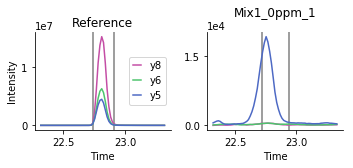

In [9]:
f = madic.plotting.plot_panel_array(tr_example, ref)

## Transition retention time agreement <a name="rt"></a>

To be confident in a peptide's presence, all transitions should co-elute with the transitions from the heavy internal standard

### (Optional) Recompute transition retention time after chromatogram smoothing <a name="recompute"></a>

If the data is noisy, the retention time selected by Skyline may be improved by smoothing the chromatogram and recalculating the retention time for each transition.

In the dataset being assessed here, recomputing the retention time has little effect. Instead, here is an example from a separate set of data where the benefit of recomputing the retention time is more clear:

In [10]:
# ----------
# Raw chromatogram
rt_ex_raw = madic.io.read_transition_report('SPD_rt_smoothing_ex_data.csv',
                                            delimiter='_',
                                            delimiter_pos=1,
                                            smooth_chromatograms=False)  # note this parameter is now set to False
# here we're just looking at light transitions and not heavy labeled standards
rt_ex_raw = rt_ex_raw[rt_ex_raw.label == 'light']


# ----------
# Smoothed chromatogram
rt_ex_smooth = madic.io.read_transition_report('SPD_rt_smoothing_ex_data.csv',
                                               delimiter='_',
                                               delimiter_pos=1,
                                               smooth_chromatograms=True)

rt_ex_smooth = rt_ex_smooth[rt_ex_smooth.label == 'light']

# recompute retention time
rt_ex_smooth = madic.qc.recompute_peak_rt(rt_ex_smooth)

No handlers could be found for logger "madic.io"


Now let's compare the chromatograms, with vertical lines representing transition retention times

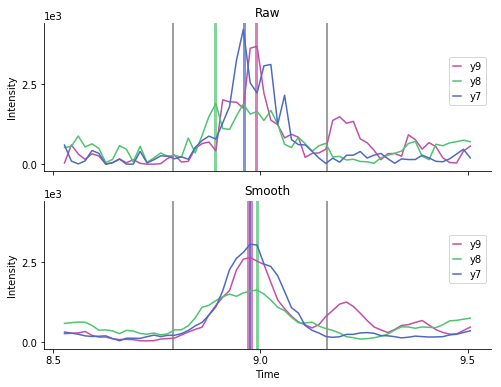

In [11]:
f, (ax_raw, ax_smooth) = plt.subplots(2, 1, figsize=(8,6), sharex=True, sharey=True)

# transition colors for vertical lines representing each transition's retention time
smoothing_trans_colors = {'y9': '#C44DA5',
                          'y8': '#4DC46D',
                          'y7': "#4D69C4"}

# ----------
# Raw chromatogram

ax_raw = madic.plotting.plot_chromatogram(rt_ex_raw, ax=ax_raw, legend=True)

# draw vertical lines
for prod_ion, rt in rt_ex_raw[['prod_ion', 'rt']].values:
    ax_raw.axvline(rt, c=smoothing_trans_colors[prod_ion], lw=3, alpha=0.7, zorder=0)

ax_raw.set_xlabel('')
ax_raw.set_title('Raw')

    
# ----------
# Smoothed chromatogram
    
ax_smooth = madic.plotting.plot_chromatogram(rt_ex_smooth, ax=ax_smooth, legend=True)

line_widths = {'y9': 6, 'y8': 3, 'y7': 2}  # better visualization of overlap

for prod_ion, rt in rt_ex_smooth[['prod_ion', 'rt']].values:
    ax_smooth.axvline(rt, c=smoothing_trans_colors[prod_ion], lw=line_widths[prod_ion], alpha=0.7, zorder=0)
    
ax_smooth.set_title('Smooth')

Here, smoothing the chromatograms and recalculating retention times decreases retention time variance; transitions y9 and y7 now actually overlap (numeric values below) and y8 is much closer to the other two.

In [12]:
rt_ex_raw[['prod_ion', 'rt']]

,prod_ion,rt
0,y9,8.99
1,y8,8.89
2,y7,8.96


In [13]:
rt_ex_smooth[['prod_ion', 'rt']]

,prod_ion,rt
0,y9,8.975567
1,y8,8.992167
2,y7,8.975567


### Assessing transition retention time agreement

Back to our original analysis, we'll continue the QC pipeline by calculating retention time agreement of light transitions with the mean retention time of heavy transitions

In [14]:
# QC retention time
df = madic.qc.recompute_peak_rt(df)
df = madic.qc.eval_retention_time(df)

Let's see what passed

In [15]:
madic.qc.summarize_results(df, level='rep')

,rep,pep,pass_transition_ratio,pass_retention_time
0,Mix1_0ppm_1,FFVAPFPEVFGK,False,True
1,Mix1_0ppm_1,YLGYLEQLLR,False,True
2,Mix1_0ppm_2,FFVAPFPEVFGK,False,False
3,Mix1_0ppm_2,YLGYLEQLLR,False,True
4,Mix1_5ppm_1,FFVAPFPEVFGK,True,True
5,Mix1_5ppm_1,YLGYLEQLLR,False,True
6,Mix1_5ppm_2,FFVAPFPEVFGK,True,True
7,Mix1_5ppm_2,YLGYLEQLLR,False,True


Peptide FFVAPFPEVFGK fails for the 0ppm_2 replicate. Let's take a closer look:

The mean heavy retention time for this replicate is:

In [16]:
df[(df.pep == 'FFVAPFPEVFGK') & (df.rep == 'Mix1_0ppm_2') & (df.label == 'heavy')].rt.mean()

23.802769999999999

Now if we compare this value to the measured light retention times:

In [17]:
# subset data
rt_example = df[(df.pep == 'FFVAPFPEVFGK') & (df.rep == 'Mix1_0ppm_2') & (df.label == 'light')]

# print data
rt_cols_to_display = ['rep', 'pep', 'prod_ion', 'rt']
rt_example[rt_cols_to_display]

,rep,pep,prod_ion,rt
1,Mix1_0ppm_2,FFVAPFPEVFGK,y9,23.81787
5,Mix1_0ppm_2,FFVAPFPEVFGK,y8,23.84807
9,Mix1_0ppm_2,FFVAPFPEVFGK,y6,23.72728


We see that the y6 transition, with a peak retention time of 23.727 does not co-elute. Visually the peak is near the left peak boundary which causes it to fail QC:

(0, 1000)

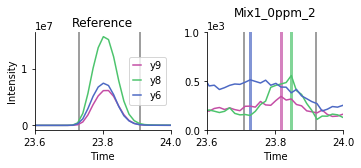

In [18]:
f = madic.plotting.plot_panel_array(rt_example, ref)

# transition colors for vertical lines representing each transition's retention time
rt_trans_colors = {'y9': '#C44DA5', 'y8': '#4DC46D', 'y6': "#4D69C4"}

# add the vertical lines
ax0, ax1 = f.get_axes()
for prod_ion, rt in rt_example[['prod_ion', 'rt']].values:
    ax1.axvline(rt, c=rt_trans_colors[prod_ion], lw=3, alpha=0.7, zorder=0)
    
# zoom in on the peak
ax0.set_xlim(23.6, 24)
ax1.set_xlim(23.6, 24)
ax1.set_ylim(0, 1000)

## Signal to noise <a name="sn"></a>

To be confident in a peak, it should be distinguished from the surrounding signal. This function sums the smoothed transition chromatograms and calculates the signal to noise as the maximum intensity within the peak boundaries to median intensity outside of the peak boundaries. The default value for passing is 3.

In [19]:
# QC signal to noise
df = madic.qc.eval_signal_to_noise(df)

Let's see what passed

In [20]:
madic.qc.summarize_results(df, level='rep')

,rep,pep,pass_transition_ratio,pass_retention_time,pass_signal_to_noise
0,Mix1_0ppm_1,FFVAPFPEVFGK,False,True,False
1,Mix1_0ppm_1,YLGYLEQLLR,False,True,True
2,Mix1_0ppm_2,FFVAPFPEVFGK,False,False,False
3,Mix1_0ppm_2,YLGYLEQLLR,False,True,True
4,Mix1_5ppm_1,FFVAPFPEVFGK,True,True,True
5,Mix1_5ppm_1,YLGYLEQLLR,False,True,True
6,Mix1_5ppm_2,FFVAPFPEVFGK,True,True,True
7,Mix1_5ppm_2,YLGYLEQLLR,False,True,True


For the failed peptide FFVAPFPEVFGK in replicate Mix1_0ppm_1, it is clear that the peak within the peak boundaries is indistinguishable from the surround signal:

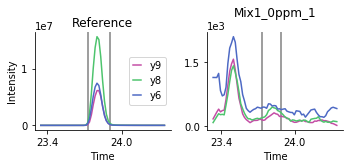

In [21]:
sn_example = df[(df.pep == 'FFVAPFPEVFGK') & (df.rep == 'Mix1_0ppm_1') & (df.label == 'light')]

f = madic.plotting.plot_panel_array(sn_example, ref)

## QC pass for all replicates <a name="rep"></a>

Finally, we want to ensure that each of the QC filters passes for both replicate injections of each of the two samples:

In [22]:
# QC the above 3 metrics for all sample replicates (must be run last)
df = madic.qc.eval_all_replicate(df)

Let's summarize the results:

In [23]:
madic.qc.summarize_results(df)

,sample_name,pep,pass_transition_ratio,pass_retention_time,pass_signal_to_noise,pass_all_replicate
0,0ppm,FFVAPFPEVFGK,False,False,False,False
1,0ppm,YLGYLEQLLR,False,True,True,False
2,5ppm,FFVAPFPEVFGK,True,True,True,True
3,5ppm,YLGYLEQLLR,False,True,True,False


We can see that the only peptide passing all filters is FFVAPFPEVFGK for the 5 ppm replicates. Specifically, the individual transition peaks co-occur within the peak boundaries (vertical grey lines), the transition ratios agree with the synthetic standard, we have a good signal to background, and both replicates agree on all of these metrics. In regards to YLGYLEQLLR it is easy to see why this peptide fails transition ratios in both 0 ppm and 5 ppm samples given the chromatograms above.

Note that each transition has been smoothed using a Savitzky-Golay filter, similar to performing the following in Skyline / Skyline-daily: View --> Transform --> Savitzky-Golay Smoothing

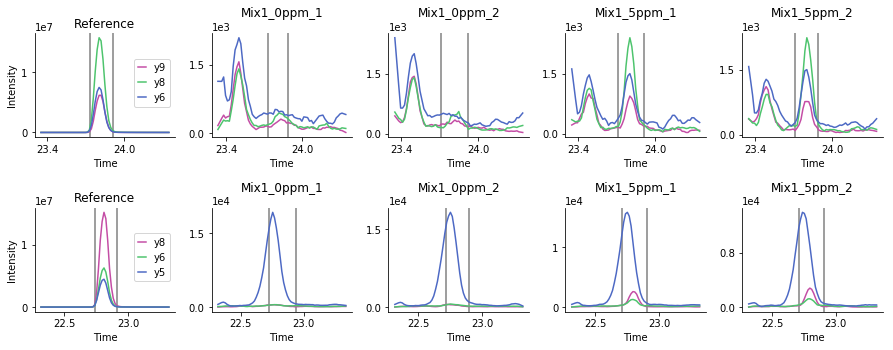

In [24]:
f = madic.plotting.plot_panel_array(data, ref)

## QC simplified <a name="simplified"></a>

While each of the above QC steps can be run individually as we've just done, the following can be used as a single command instead (for convenience):
```
df = madic.qc.eval_data(data, ref)
```

# Identifying interference <a name="interference"></a>

The `identify_interference` routine adds a new bool column to the dataframe indicating the presence of interference in a transition

In [25]:
df = madic.interference.identify_interference(df)

We can see the YLGYLEQLLR y5 product ion has interference in all replicates:

In [26]:
# subset to only rows where interference = True
interference_cols = ['sample_name', 'rep', 'pep', 'prod_ion', 'label', 'interference']

df[df.interference][interference_cols]

,sample_name,rep,pep,prod_ion,label,interference
28,0ppm,Mix1_0ppm_1,YLGYLEQLLR,y5,light,True
29,0ppm,Mix1_0ppm_2,YLGYLEQLLR,y5,light,True
30,5ppm,Mix1_5ppm_1,YLGYLEQLLR,y5,light,True
31,5ppm,Mix1_5ppm_2,YLGYLEQLLR,y5,light,True


## Interference correction <a name="correction"></a>

In the absence of interference, would the remaining YLGYLEQLLR transitions enable to peptide to pass the quality control filters?

Let's rerun the pipeline

In [27]:
df_rerun = madic.qc.eval_data(df, ref)

In [28]:
madic.qc.summarize_results(df_rerun)

,sample_name,pep,pass_transition_ratio,pass_signal_to_noise,pass_retention_time,pass_all_replicate,interference_corrected
0,0ppm,FFVAPFPEVFGK,False,False,False,False,False
1,0ppm,YLGYLEQLLR,False,True,True,False,True
2,5ppm,FFVAPFPEVFGK,True,True,True,True,False
3,5ppm,YLGYLEQLLR,True,True,True,True,True


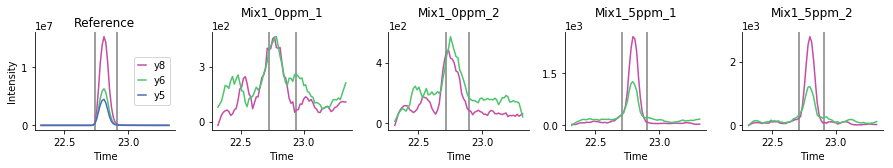

In [29]:
YLG = df_rerun[(df_rerun.pep=='YLGYLEQLLR')]
f = madic.plotting.plot_panel_array(YLG, ref=ref, ignore_interference=True)

Now we see that YLGYLEQLLR for the 5 ppm replicates passes once interference corrected. Importantly, the 0 ppm YLGYLEQLLR replicates still fail even after interference correction

That's it for the the quick introduction! If you have any issues or suggestions feel free to let me know on the <a href="https://github.com/dcroote/madic/issues">Github issue tracker</a>.